# Кластеризация: иерархическая кластеризация

В данной тетради рассматривается решение задачи кластерного анализа алгоритмами иерархической кластеризации. Показаны возможности библиотек Python непосредственно по решению задачи кластеризации, извлечению нужной структуры кластеров и их графического представления.    
Общая схема решения задачи:     
1. Чтение исходных данных (формат файла, формат записей, кодировка и т.п.);
2. Получение предварительной информации об имеющимся массива (просмотр заголовков, размерность, просмотр части данных, получение информации о типах данных, преобразование типов, поиск пропусков, заполнение пропусков);
3. Аккуратные данные (поиск и заполнение пропусков, поиск и удаление дубликатов, формирование итогового набора данных для кластеризации);
4. Иерархическая кластеризация: агломеративный алгоритм.


Дополнительные источники для изучения указаны в конце настоящей тетради. 

## 1. Чтение исходных данных

Для ознакомления с необходимым материал рекомендую книгу [1, глава 6, стр. 175].     
В рассматриваемом примере исходные данные хранятся в txt-файле, разделенные знаком табуляции.    
Для чтения воспользуемся функцией `.read_table()`.    
В качестве параметров передадим
- `path` -- путь к файлу;
- `encoding` -- исходную кодировку, в которой хранятся данные;
- `sep` -- последовательность символов или регулярное выражение, служащее для разделения полей в строке: ',',';','\t'(знак табуляции), '\s+' -- если поля разделены переменным числом пробелов;
- `nrows` -- количество читаемых строк от начала файла.

Подключаем библиотеку `pandas` и загружаем исходные данные в датафрейм `df`. 

ВАЖНО: В данном случае с целью упрощения и повышения производительности прочитаны только первых 100 строк исходного массива.

In [1]:
import pandas as pd
pd.set_option('display.precision',3)
df=pd.read_table('mobile.txt', encoding='1251', sep='\t', nrows=100)

## 2. Получение предварительной информации об имеющимся массива   

Для получения предварительной информации об анализируемом массиве можно воспользоваться следующими возможностями Python    
- Просмотр с помощью свойства `.head()` указанного числа первых строк датафрейма. По умолчанию выводится 5 первых строк датафрейма;
- Размерность датафрейма можно узнать с помощью свойства .shape;
- Просмотр заголовков столбов с помощью свойства .columns;
- Просмотр информации о типах переменных с помощью свойства `.info()`

In [2]:
df.head()

,Код,Возраст,Среднемесячный расход,Средняя продолжительность разговоров,Звонков днем за месяц,Звонков вечером за месяц,Звонков ночью за месяц,Звонки в другие города,Звонки в другие страны,Доля звонков на стационарные телефоны,Количество SMS за месяц
0,0,24,121.54,2.4,12,65,5,0,0,5,56
1,1,51,287.51,1.7,111,109,1,44,0,6,1
2,2,41,113.70,2.1,41,27,0,0,0,1,36
3,3,35,410.23,5.6,47,49,0,0,0,11,23
4,4,26,537.60,4.8,58,77,4,0,0,16,29


In [3]:
df.iloc[:,1:6:2]

,Возраст,Средняя продолжительность разговоров,Звонков вечером за месяц
0,24,2.4,65
1,51,1.7,109
2,41,2.1,27
3,35,5.6,49
4,26,4.8,77
...,...,...,...
95,29,18.2,78
96,54,1.1,68
97,25,3.7,45
98,54,2.8,98


ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: С помощью свойства `.tail()` можно просмотреть заданное число последних строк массива. По умолчанию выводится 5 строк 

+ Размерность датафрейма можно узнать с помощью свойства `.shape`    
ДОПОЛНИТЕЛЬНАЯ ИНФОРМАЦИЯ: количество строк датафрейма можно узнать с помощью метода `len()`

In [4]:
df.shape

(100, 11)

+ Просмотр заголовков столбов с помощью свойства `.columns` 

In [5]:
df.columns

Index(['Код', 'Возраст', 'Среднемесячный расход',
       'Средняя продолжительность разговоров', 'Звонков днем за месяц',
       'Звонков вечером за месяц', 'Звонков ночью за месяц',
       'Звонки в другие города', 'Звонки в другие страны',
       'Доля звонков на стационарные телефоны', 'Количество SMS за месяц'],
      dtype='object')

## 3. Аккуратные данные

Аккуратные данные --- данные, пригодные для дальнейшего анализа. Для получения аккуратных данных необходимо разрешить следующие проблемы, связанные с имеющимися данными (список может быть расширен):     
- имена объектов или признаков отличаются от желаемых (требуемых);  
- есть пропущенные данные;
- значения указаны не в тех единицах измерения, которые требуются;
- временной период выборки наблюдений не тот;
- переменные являются категориальными, а требуются количественные;
- присутсвует шум в данных;
- информация неверного типа;
- данные неправильно ориентированы по осям;
- данные неправильно нормализованы;
- данные дублизуются.

## 3.1 Поиск и импутация пропущенных наблюдений
- Вывод общей информации о наличие пропусков во всех переменных можно осуществить, воспользовавшись цепочкой методов `.isnull()` и `.sum()`

In [6]:
df.isnull().sum()

Код                                      0
Возраст                                  0
Среднемесячный расход                    0
Средняя продолжительность разговоров     0
Звонков днем за месяц                    0
Звонков вечером за месяц                 0
Звонков ночью за месяц                   0
Звонки в другие города                   0
Звонки в другие страны                   0
Доля звонков на стационарные телефоны    0
Количество SMS за месяц                  0
dtype: int64

## 3.2 Типы признаков

Для просмотра информации о типах наблюдаемых признаков у объектов воспользуемся свойством `.info()`

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
Код                                      100 non-null int64
Возраст                                  100 non-null int64
Среднемесячный расход                    100 non-null float64
Средняя продолжительность разговоров     100 non-null float64
Звонков днем за месяц                    100 non-null int64
Звонков вечером за месяц                 100 non-null int64
Звонков ночью за месяц                   100 non-null int64
Звонки в другие города                   100 non-null int64
Звонки в другие страны                   100 non-null int64
Доля звонков на стационарные телефоны    100 non-null int64
Количество SMS за месяц                  100 non-null int64
dtypes: float64(2), int64(9)
memory usage: 8.7 KB


## 3.3 Генерирование входного массива и нормализация признаков 

In [8]:
X=df.iloc[:,:].values
X=(X-X.mean(axis=0))/X.std(axis=0)
#print(X.mean(axis=0)) #просмотр массива выборочных средних -- они должны быть равны 0 
#print(X.std(axis=0)) # просмотр массива стандартных отклонений --- они должны быть равными 1
#print(X) # просмотр входного массива --- аккуратные данные!!!!

## 4. Иерархическая кластеризация: агломеративный алгоритм  

Для изучания материала рекомендуется воспользоваться ресурсом [2]    
Иерархическая кластеризация реализована в модуле `scipy.cluster.hierarchy`.    
Импортируем из этого модуля методы:    
- `.linkage()` -- выполняет иерархическую (агломеративную) кластеризацию; 
- `.fcluster()` -- 
- `.dendrogram()` -- строит дендрограмму.  

Метод `.linkage()` имеет следующую спецификацию `linkage(y[, method, metric, optimal_ordering])`:    
- y -- матрица попарных расстояний или исходных данных (в матрице не должно быть пробелов или категориальных значений)
- method -- правило, по которому будут рассчитываться расстояния между кластерами:    
    - `single`
    - `complete`
    - `average`
    - `weighted`
    - `centroid`
    - `median`
    - `ward`
- metric -- метрика: `braycurtis`, `canberra`, `chebyshev`, `cityblock`, `correlation`, `cosine`, `dice`, `euclidean`, `hamming`, `jaccard`, `jensenshannon`, `kulsinski`, `mahalanobis`, `matching`, `minkowsk`, `rogerstanimoto`, `russellrao`, `seuclidean`, `sokalmichener`, `sokalsneath`, `sqeuclidean`, `yule`.

In [11]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt
import numpy as np

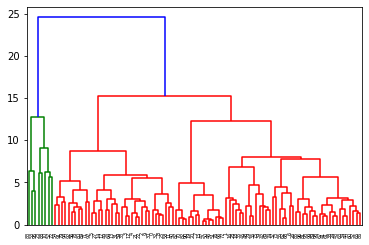

In [12]:
mergings = linkage(X, method='ward') #complete, single
r=plt.figure()
dendrogram(mergings)
r.savefig('1.png', dpi = 300)

In [13]:
pd.set_option('display.precision',3)
print(mergings)

[[ 47.          50.           0.4064717    2.        ]
 [ 46.          51.           0.57310023   2.        ]
 [ 82.          90.           0.6078101    2.        ]
 [100.         101.           0.60829392   4.        ]
 [ 70.         102.           0.7341558    3.        ]
 [ 62.          68.           0.74577465   2.        ]
 [ 66.          77.           0.79800266   2.        ]
 [ 76.         106.           0.89208984   3.        ]
 [ 19.          20.           0.9228828    2.        ]
 [ 21.          22.           0.92367274   2.        ]
 [ 89.          98.           1.01020099   2.        ]
 [ 34.          44.           1.02297361   2.        ]
 [ 24.          43.           1.0234665    2.        ]
 [ 41.          61.           1.0512902    2.        ]
 [  3.          12.           1.05601407   2.        ]
 [ 29.          36.           1.05631448   2.        ]
 [  8.          25.           1.1240306    2.        ]
 [  7.          15.           1.12867273   2.        ]
 [ 32.    

Литература
1. Маккинли У. Python и анализ данных. - М.: ДМК Пресс, 2015. – 482 с.
2. https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/
3. https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html